In [1]:
%matplotlib inline 
import requests
import pandas as pd
import json
import pickle
import geopandas as gpd
import matplotlib 
import matplotlib.pyplot as plt
from pyquadkey2 import quadkey
from pyquadkey2.quadkey import QuadKey
from pyquadkey2.quadkey import TileAnchor, QuadKey
from shapely.geometry import Point, LineString, Polygon

Requirments: 

- #pip install pyquadkey2

Resources: 
- Description of Quadkeys https://docs.microsoft.com/en-us/bingmaps/articles/bing-maps-tile-system 
- Library to work with lat lon and QuadKeys https://github.com/CartoDB/python-quadkey 
- Methodlogy paper https://arxiv.org/ftp/arxiv/papers/2104/2104.07761.pdf 
- OSM page for getting the tiles based on coordinate system https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames#Lon..2Flat._to_tile_numbers_2
- Python library documentation 
https://docs.muetsch.io/pyquadkey2/ 
- The RWI data is available here: https://data.humdata.org/dataset/relative-wealth-index choose the data that includes the Quadkeys. the data will be downloaded as bulk and includes all csv's for the RWI data.


QuadKeys: 
- the length of the quad key is the level of detail it refers to (longest = more granular level) 
- parent -child relationship: tile 2 is the perant of tile 20 

Our data is in zoom level 14, which is 9.555 meters/pixel resolution 

Workflow: 

- Use FB data to populate the list of Quadkeys (QK)
- Use the pyquadkey2 library to get four cooordinates for each QK: SW, NE, SE, NW 
- Use each for cooridnate set to create the tile data 
- Tranform into polygons, merge back with the FB data: this will result in a polygon type shapefile, each row represents one QK for a point 
- Export data 


* 2.4Km2 is aproximatly 5.76 km2 area 
* looking into the QuadKeys it seems as though the nearest tile size is 5982842.156102487 Square meteres
* this measurment is closest to tiles sized 2.447 KM (length and width)
* Coordinate system is WGS 84 datum. 
* FB data uses level 14 data, each Quadkey is reprsented by 14 digits 

## Approach: 
Use data from FB which already includes QuadKeys




# Plug-in FB data + AOI 

In [2]:
# AOI Kolkata
aoi = gpd.read_file('admin/rubavu_AOI_4326.shp')

In [3]:
# fb data for India 
FB_QKdata = pd.read_csv('data/RWA_relative_wealth_index.csv')
FB_QKdata.head()

,quadkey,latitude,longitude,rwi,error
0,30010103012123,-1.658704,30.003662,-0.378,0.393
1,30010101233303,-1.351193,30.179443,0.385,0.321
2,30010101223313,-1.351193,29.871826,-0.209,0.297
3,30010102320130,-2.515061,28.970947,0.457,0.324
4,30010103310023,-2.185749,30.618897,-0.281,0.290


In [4]:
# change quadkey format to str
FB_QKdata["quadkey1"] = FB_QKdata["quadkey"].astype('str')

In [5]:
FB_QKdata.dtypes

quadkey        int64
latitude     float64
longitude    float64
rwi          float64
error        float64
quadkey1      object
dtype: object

In [6]:
# fill 13 digit quadkeys with 0 before the QK
FB_QKdata['quadkey1'] = FB_QKdata['quadkey1'].apply(lambda x: x.zfill(14))

In [7]:
# take column with quadkeys and transform it to list and then to QuadKey object
fb_qk = FB_QKdata["quadkey1"].tolist()
FB_QK = [QuadKey(i) for i in fb_qk]

In [8]:
# locate the four corners of QuadKey tiles
SW = []
NE = []
SE = []
NW = []

for i in FB_QK:
    #south west point
    sw = i.to_geo(anchor=TileAnchor.ANCHOR_SW)
    SW.append(sw) 
    #north west point
    ne = i.to_geo(anchor=TileAnchor.ANCHOR_NE)
    NE.append(ne) 
    #south east point 
    se = i.to_geo(anchor=TileAnchor.ANCHOR_SE)
    SE.append(se)
    #north west point 
    nw = i.to_geo(anchor=TileAnchor.ANCHOR_NW)
    NW.append(nw)

In [9]:
# check intermediate output
SW[5]

(-1.252342, 30.498047)

In [10]:
# flip lat and lon for tile corner coordinates
swFinal = [(i[1], i[0]) for i in SW]
neFinal = [(i[1], i[0]) for i in NE]
seFinal = [(i[1], i[0]) for i in SE]
nwFinal = [(i[1], i[0]) for i in NW]

In [11]:
# check intermediate output
print(nwFinal[1:3])
print(seFinal[1:3])
print(neFinal[1:3])
print(swFinal[1:3])

[(30.168457, -1.34021), (29.86084, -1.34021)]
[(30.19043, -1.362176), (29.882813, -1.362176)]
[(30.19043, -1.34021), (29.882813, -1.34021)]
[(30.168457, -1.362176), (29.86084, -1.362176)]


In [12]:
# check the lat and lon are indeed flipped
SW[1]

(-1.362176, 30.168457)

In [13]:
# generate Polygon object based on four corner coordinates
tiledata = [Polygon([nw, sw, se, ne]) for sw, ne, se, nw in zip(swFinal, neFinal, seFinal, nwFinal)]

In [14]:
# create GeoDataFrame with Polygons
crs = ("epsg:4326")
gdf = gpd.GeoDataFrame(geometry = tiledata, crs = crs)

In [15]:
# make sure aoi crs is the same
aoi.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

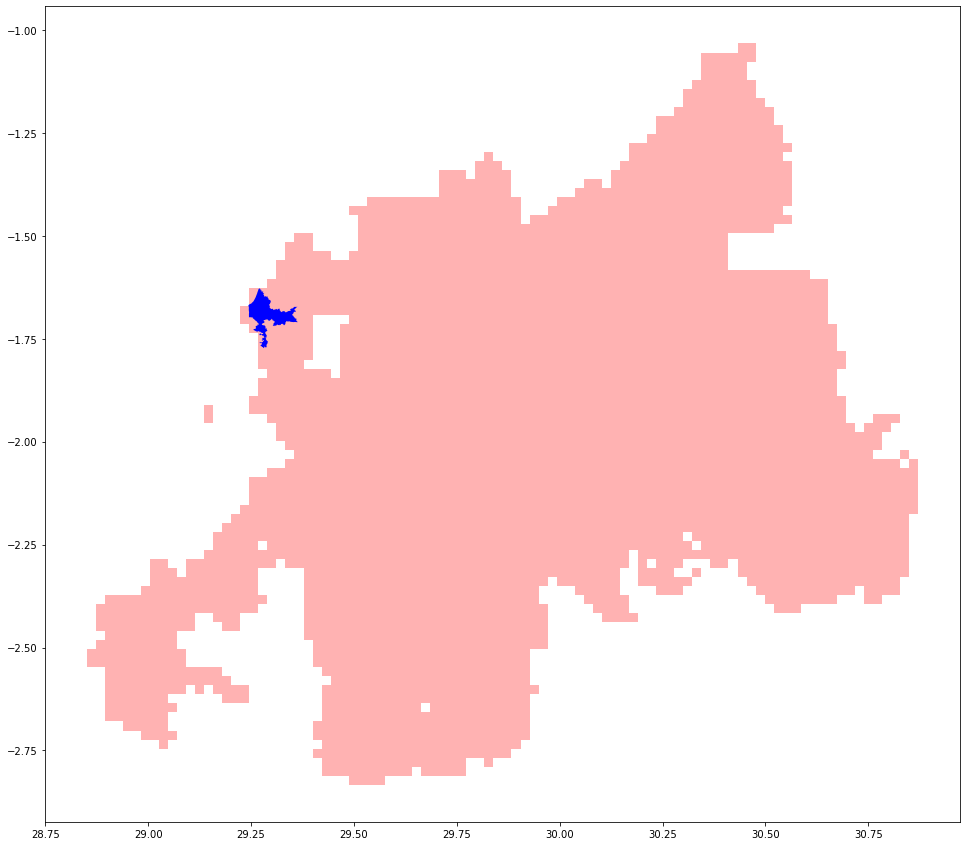

In [16]:
# plot country and aoi
base = gdf.plot(color = 'red', figsize = (20, 15), alpha = 0.3)
aoi.plot(ax = base, color = 'blue')

In [17]:
# add QuadKeys to gdf
gdf['quadkey'] = FB_QK
gdf

,geometry,quadkey
0,"POLYGON ((29.99268 -1.64772, 29.99268 -1.66969...",30010103012123
1,"POLYGON ((30.16846 -1.34021, 30.16846 -1.36218...",30010101233303
2,"POLYGON ((29.86084 -1.34021, 29.86084 -1.36218...",30010101223313
3,"POLYGON ((28.95996 -2.50408, 28.95996 -2.52604...",30010102320130
4,"POLYGON ((30.60791 -2.17477, 30.60791 -2.19673...",30010103310023
...,...,...
3710,"POLYGON ((29.99268 -1.91127, 29.99268 -1.93323...",30010103030323
3711,"POLYGON ((30.34424 -2.26260, 30.34424 -2.28455...",30010103300323
3712,"POLYGON ((30.23438 -2.19673, 30.23438 -2.21868...",30010103300200
3713,"POLYGON ((30.67383 -2.21868, 30.67383 -2.24064...",30010103310302


In [18]:
FB_QKdata

,quadkey,latitude,longitude,rwi,error,quadkey1
0,30010103012123,-1.658704,30.003662,-0.378,0.393,30010103012123
1,30010101233303,-1.351193,30.179443,0.385,0.321,30010101233303
2,30010101223313,-1.351193,29.871826,-0.209,0.297,30010101223313
3,30010102320130,-2.515061,28.970947,0.457,0.324,30010102320130
4,30010103310023,-2.185749,30.618897,-0.281,0.290,30010103310023
...,...,...,...,...,...,...
3710,30010103030323,-1.922247,30.003662,0.494,0.384,30010103030323
3711,30010103300323,-2.273573,30.355225,-0.249,0.291,30010103300323
3712,30010103300200,-2.207705,30.245361,0.640,0.386,30010103300200
3713,30010103310302,-2.229662,30.684815,-0.145,0.320,30010103310302


In [19]:
gdf.dtypes

geometry    geometry
quadkey       object
dtype: object

In [20]:
# change type of quadkey column to str
gdf["quadkey"] = gdf["quadkey"].astype('str')

In [21]:
# merge gdf and fb data
gdf = gdf.merge(FB_QKdata, left_on = 'quadkey', right_on = 'quadkey1', how = 'inner')

In [22]:
gdf[3003:3006]

,geometry,quadkey_x,quadkey_y,latitude,longitude,rwi,error,quadkey1
3003,"POLYGON ((30.43213 -1.77950, 30.43213 -1.80146...",30010103121003,30010103121003,-1.790480,30.443115,-0.261,0.334,30010103121003
3004,"POLYGON ((29.55322 -1.49397, 29.55322 -1.51594...",30010103000201,30010103000201,-1.504954,29.564209,-0.407,0.456,30010103000201
3005,"POLYGON ((30.45410 -2.04302, 30.45410 -2.06498...",30010103123212,30010103123212,-2.054003,30.465088,-0.098,0.306,30010103123212


<AxesSubplot:>

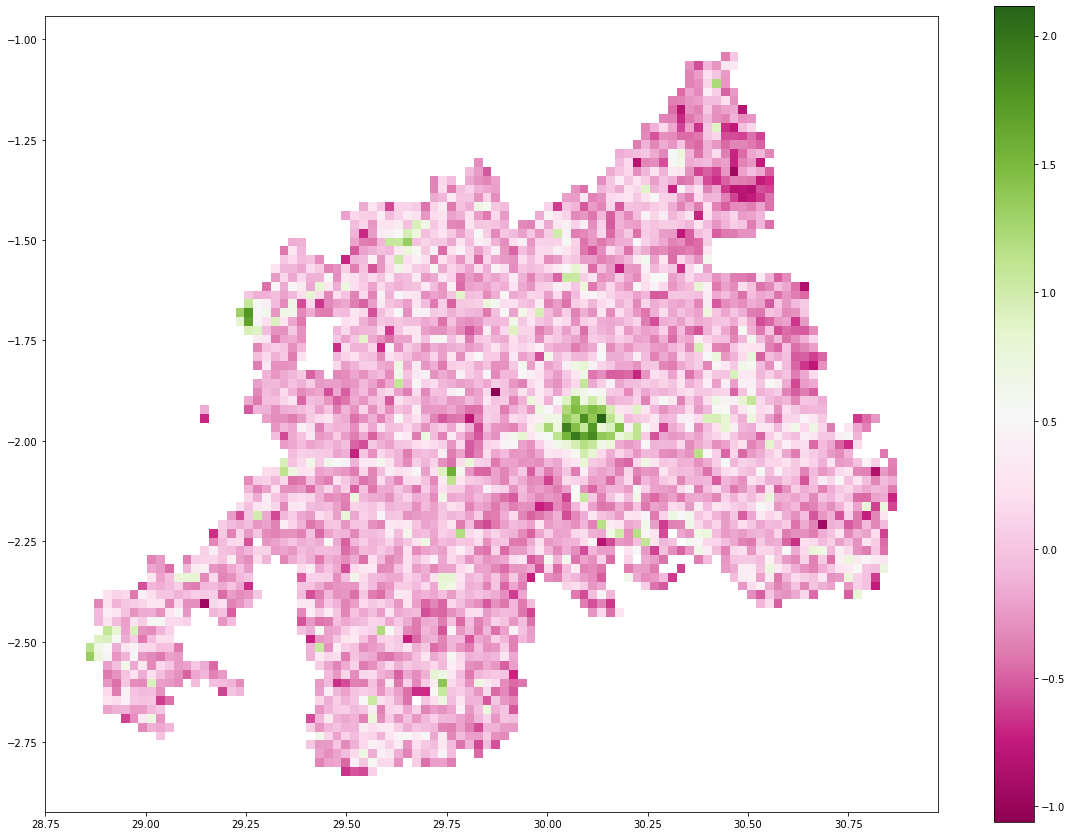

In [23]:
# plot choropleth map of RWI
gdf.plot(column = 'rwi', cmap = 'PiYG', figsize = (20, 15), legend = True)

<AxesSubplot:>

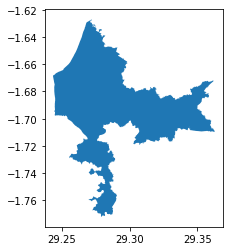

In [24]:
aoi.plot()

In [29]:
# export to shapefile
gdf_aoi = gpd.clip(gdf, aoi)

In [30]:
gdf_aoi.to_file("output/FB_QK_data_rubavu.shp")

In [31]:
# produce summary stats
gdf_aoi.describe()

NameError: name 'gdf_aoi' is not defined